In [1]:
from rsome import ro
from rsome import grb_solver as grb
import rsome as rso
import numpy as np

n = 30                                     # number of stocks
i = np.arange(1, n+1)                       # indices of stocks
p = 1.15 + i*0.05/n                       # mean returns
sigma = 0.05/450 * (2*i*n*(n+1))**0.5       # standard deviations of returns
phi = 5                                     # constant phi

model = ro.Model('mv-portfolio')            # create an RSOME model

x = model.dvar(n)                           # fractions of investment

Q = np.diag(sigma**2)                       # covariance matrix
model.max(p@x - phi*rso.quad(x, Q))         # mean-variance objective
model.st(x.sum() == 1)                      # summation of x is one
model.st(x >= 0)                            # x is non-negative

model.solve(grb)

Restricted license - for non-production use only - expires 2024-10-28
Being solved by Gurobi...
Solution status: 2
Running time: 0.0015s


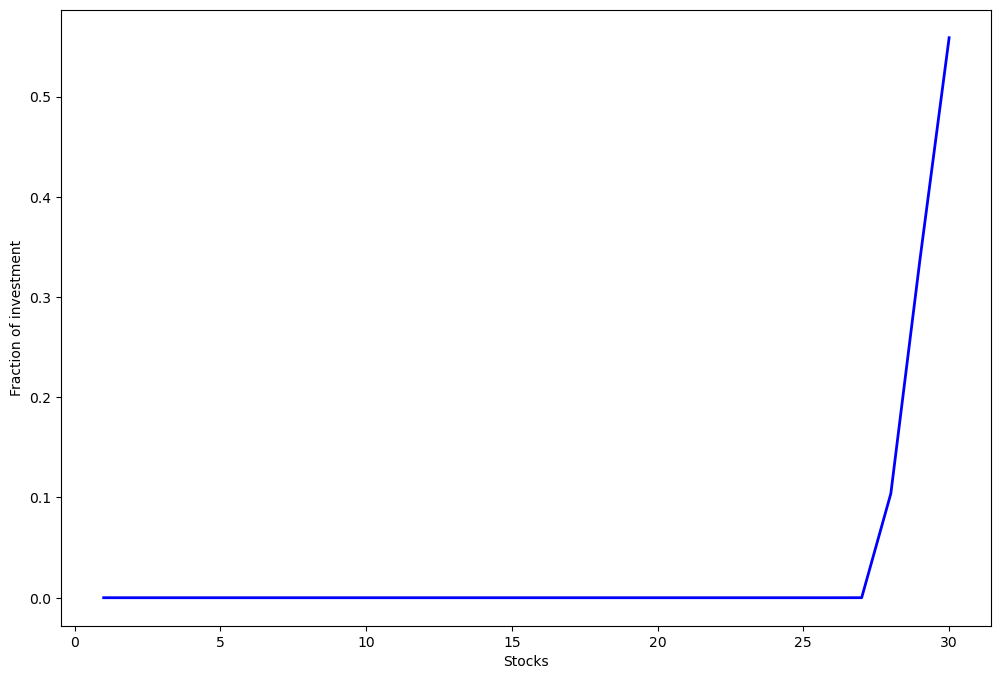

Objective value: 1.1976


In [2]:
import matplotlib.pyplot as plt

obj_val = model.get()                   # the optimal objective value
x_sol = x.get()                         # the optimal investment decision
plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(range(1, n+1), x_sol,
         linewidth=2, color='b')
plt.xlabel('Stocks')
plt.ylabel('Fraction of investment')
plt.show()
print('Objective value: {0:0.4f}'.format(obj_val))

In [3]:
# mean-variance optimization with maximizing expected return and constraint risk
Sigma = sigma*sigma

model = ro.Model('mv-portfolio')            # create an RSOME model

x = model.dvar(n)                           # fractions of investment
Q = np.diag(sigma**2)                       # covariance matrix
model.max(p@x)         # mean-variance objective
model.st( rso.quad(x, Q) - Sigma <=0 )              # constraint with variance
model.st(x.sum() == 1)                      # summation of x is one
model.st(x >= 0)                            # x is non-negative

model.solve(grb)

Being solved by Gurobi...
Solution status: 2
Running time: 0.0008s


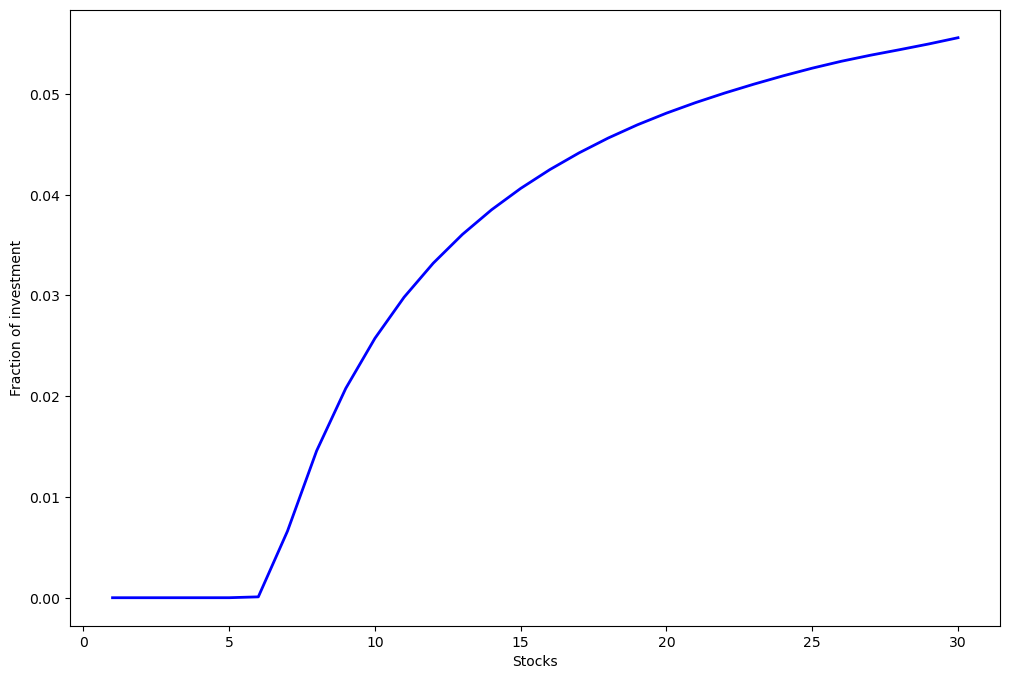

Objective value: 1.1842


In [4]:
obj_val = model.get()                   # the optimal objective value
x_sol = x.get()                         # the optimal investment decision
plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(range(1, n+1), x_sol,
         linewidth=2, color='b')
plt.xlabel('Stocks')
plt.ylabel('Fraction of investment')
plt.show()
print('Objective value: {0:0.4f}'.format(obj_val))

In [5]:
# the portfolio construction problem discussed in the previous sections is solved by a robust optimization approach introduced in the paper Bertsimas and Sim (2004). 
# The robust model is presented below.

In [6]:
n = 30                                 # number of stocks
i = np.arange(1, n+1)                   # indices of stocks
p = 1.15 + i*0.05/150                   # mean returns
delta = 0.05/450 * (2*i*n*(n+1))**0.5   # deviations of returns
Gamma = 5                               # budget of uncertainty

model = ro.Model()              
x = model.dvar(n)                       # fractions of investment
z = model.rvar(n)                       # random variables

model.maxmin((p + delta*z) @ x,         # the max-min objective
             rso.norm(z, np.infty) <=1, # uncertainty set constraints
             rso.norm(z, 1) <= Gamma)   # uncertainty set constraints
model.st(sum(x) == 1)                   # summation of x is one
model.st(x >= 0)                        # x is non-negative

model.solve(grb)   

Being solved by Gurobi...
Solution status: 2
Running time: 0.0016s


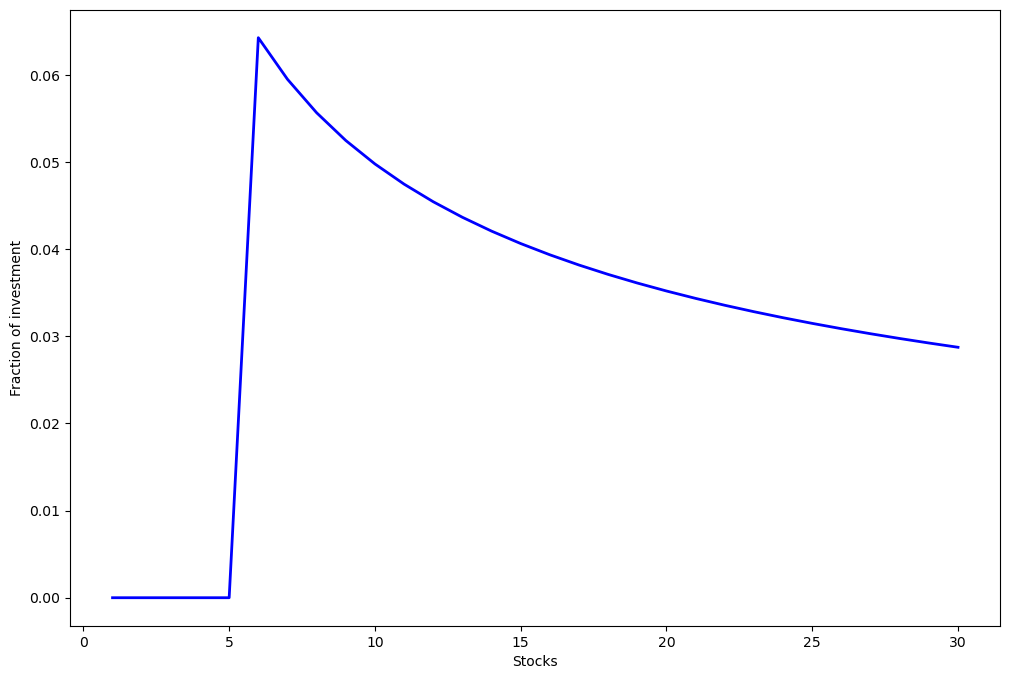

Objective value: 1.1517


In [7]:
obj_val = model.get()                   # the optimal objective value
x_sol = x.get()                         # the optimal investment decision

plt.plot(range(1, n+1), x_sol, linewidth=2, color='b')
plt.xlabel('Stocks')
plt.ylabel('Fraction of investment')
plt.show()
print('Objective value: {0:0.4f}'.format(obj_val))

In [24]:
import pandas as pd
import yfinance as yf

stocks = ['JPM', 'AMZN', 'TSLA', 'AAPL', 'GOOG', 'ZM', 'META', 'MCD']
start = '2021-1-2'              # starting date of historical data
end='2021-12-31'                # end date of historical data

data = pd.DataFrame([])
for stock in stocks:
    each = yf.Ticker(stock).history(start=start, end=end)
    close = each['Close'].values
    returns = (close[1:] - close[:-1]) / close[:-1]
    data[stock] = returns

data

,JPM,AMZN,TSLA,AAPL,GOOG,ZM,META,MCD
0,0.005441,0.010004,0.007317,0.012364,0.007337,0.002361,0.007548,0.005994
1,0.046956,-0.024897,0.028390,-0.033662,-0.003234,-0.045506,-0.028269,-0.002270
2,0.032839,0.007577,0.079447,0.034123,0.029943,-0.005546,0.020622,0.004644
3,0.001104,0.006496,0.078403,0.008631,0.011168,0.020759,-0.004354,0.018351
4,0.014924,-0.021519,-0.078214,-0.023249,-0.022405,-0.034038,-0.040102,-0.007597
...,...,...,...,...,...,...,...,...
245,0.003574,0.000184,0.057619,0.003644,0.001317,-0.007663,0.014495,0.003812
246,0.005723,-0.008178,0.025248,0.022975,0.006263,-0.021967,0.032633,0.008611
247,0.003035,0.005844,-0.005000,-0.005767,-0.010914,-0.019580,0.000116,-0.001342
248,-0.000504,-0.008555,-0.002095,0.000502,0.000386,-0.010666,-0.009474,0.002277


In [25]:
y = data.values     # stock data as an array
s, n = y.shape      # s: sample size; n: number of stocks

x_lb = np.zeros(n)  # lower bounds of investment decisions
x_ub = np.ones(n)   # upper bounds of investment decisions

beta =0.95          # confidence interval
w0 = 1              # investment budget
mu = 0.001          # target minimum expected return rate

In [26]:
# Acquire a mosek licence for academic use valid for one year: https://www.mosek.com/license/request/?i=acp
# place the licence file under the designated folder depending on the OS you use.

In [27]:
from rsome import msk_solver as msk

In [28]:
model = ro.Model()

pi = np.ones(s) / s

x = model.dvar(n)
u = model.dvar(s)
alpha = model.dvar()

model.min(alpha + 1/(1-beta) * (pi@u))
model.st(u >= -y@x - alpha)
model.st(u >= 0)
model.st(pi@y@x >= mu)
model.st(x >= x_lb, x <= x_ub, x.sum() == w0)

model.solve(msk)

Being solved by Mosek...
Solution status: Optimal
Running time: 0.0123s


In [29]:
x_nom = x.get()
model.get()

0.018195313675492132

In [30]:
# consider a box uncertainty set 
# Now we consider a box uncertainty set

# $Π={ππ:ππ=ππ0+ηη,11⊤ηη=0,ηη⎯⎯≤ηη≤ηη¯}$.
# In this case study, we assume that −ηη⎯⎯=ηη¯=0.0001
# , and the Python code for implementation is provided below.

In [31]:
model = ro.Model()

eta_ub = 0.0001                 # upper bound of eta
eta_lb = -0.0001                # lower bound of eta

eta = model.rvar(s)             # eta as random variables
uset = (eta.sum() == 0,
        eta >= eta_lb,
        eta <= eta_ub)
pi = 1/s + eta                  # pi as inexact probabilities

x = model.dvar(n)
u = model.dvar(s)
alpha = model.dvar()

model.minmax(alpha + 1/(1-beta) * (pi@u), uset)
model.st(u >= -y@x - alpha)
model.st(u >= 0)
model.st(pi@y@x >= mu)
model.st(x >= x_lb, x <= x_ub, x.sum() == w0)

model.solve(msk)

Being solved by Mosek...
Solution status: Optimal
Running time: 0.0503s


In [33]:
x_box = x.get()
model.get()

0.01854117122162172

In [34]:
# visualization

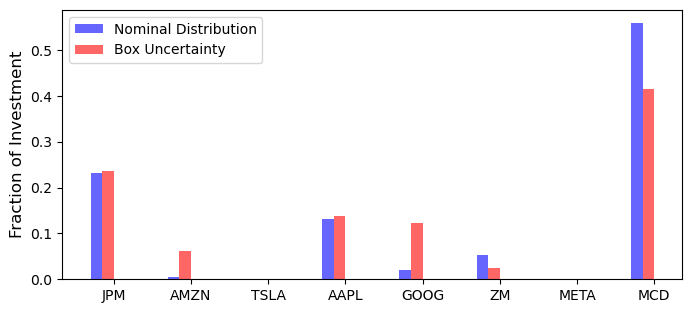

In [35]:
xdata = np.arange(n)
width = 0.15

plt.figure(figsize=(8, 3.5))
plt.bar(xdata - 1.5*width, x_nom, 
        width=width, color='b', alpha=0.6, label='Nominal Distribution')
plt.bar(xdata - 0.5*width, x_box, 
        width=width, color='r', alpha=0.6, label='Box Uncertainty')

plt.legend()
plt.ylabel('Fraction of Investment', fontsize=12)
plt.xticks(xdata, data.columns)
plt.show()